In [9]:
# Cell 0: Setup
from pathlib import Path
import numpy as np
import pandas as pd
import joblib
import scipy.sparse
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

BASE = Path("..")
DATA_INTERIM = BASE / "data" / "interim"
MODEL_DIR = BASE / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

print("✅ Paths ready")


✅ Paths ready


In [10]:
# Cell 1: Load engineered features & target
X = scipy.sparse.load_npz(DATA_INTERIM / "X_features.npz")
y = np.load(DATA_INTERIM / "y_target.npy")

print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: (19098, 86)
Target shape: (19098,)


In [11]:
# Cell 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])


Train size: 15278 Test size: 3820


In [12]:
# Cell 3: Helper function for evaluation
from math import sqrt

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    mse = mean_squared_error(y_test, preds)
    rmse = sqrt(mse)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    
    print(f"{name} -> RMSE: {rmse:,.0f}, MAE: {mae:,.0f}, R²: {r2:.3f}")
    return {"Model": name, "RMSE": rmse, "MAE": mae, "R2": r2, "TrainedModel": model}


In [13]:
# Cell 4: Try baseline models
results = []

# Linear Regression
linreg = LinearRegression()
results.append(evaluate_model("Linear Regression", linreg, X_train, y_train, X_test, y_test))

# Decision Tree
dt = DecisionTreeRegressor(max_depth=10, random_state=42)
results.append(evaluate_model("Decision Tree", dt, X_train, y_train, X_test, y_test))

# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
results.append(evaluate_model("Random Forest", rf, X_train, y_train, X_test, y_test))

# Gradient Boosting
gb = GradientBoostingRegressor(random_state=42)
results.append(evaluate_model("Gradient Boosting", gb, X_train, y_train, X_test, y_test))


Linear Regression -> RMSE: 61,839, MAE: 18,634, R²: 0.174
Decision Tree -> RMSE: 72,445, MAE: 15,159, R²: -0.134
Random Forest -> RMSE: 65,745, MAE: 14,345, R²: 0.066
Gradient Boosting -> RMSE: 61,067, MAE: 15,592, R²: 0.194


In [15]:
# Cell 5: Compare results in a table
results_df = pd.DataFrame(results).drop(columns=["TrainedModel"])
results_df


,Model,RMSE,MAE,R2
0,Linear Regression,61838.793257,18633.809875,0.173638
1,Decision Tree,72445.443181,15159.045661,-0.134150
2,Random Forest,65744.809270,14344.677310,0.065947
3,Gradient Boosting,61067.416708,15592.288910,0.194125


In [16]:
# Cell 6: Pick best model and save
best = min(results, key=lambda x: x["RMSE"])  # choose lowest RMSE
final_model = best["TrainedModel"]

joblib.dump(final_model, MODEL_DIR / "storm_damage_model.joblib")
print("✅ Best model saved:", best["Model"], "->", MODEL_DIR / "storm_damage_model.joblib")


✅ Best model saved: Gradient Boosting -> ..\models\storm_damage_model.joblib


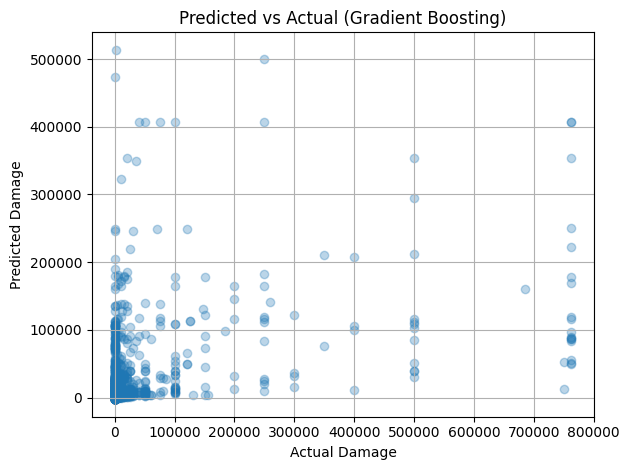

In [17]:
# Cell 7: Plot predicted vs actual
preds = final_model.predict(X_test)

plt.scatter(y_test, preds, alpha=0.3)
plt.xlabel("Actual Damage")
plt.ylabel("Predicted Damage")
plt.title(f"Predicted vs Actual ({best['Model']})")
plt.grid(True)
plt.tight_layout()
plt.show()
